#**Introduction**

This project is about **Cyber Abuse Detection** in Urdu text. The main goal is to build a machine learning model that can automatically detect abusive comments written in Urdu.

Social media platforms contain a lot of negative and offensive comments. Detecting these comments is important to create a safer online environment. Since most existing research focuses on English, this project uses Urdu data, which makes it unique and useful for our local context.

##**Steps I will follow in this notebook:**

**1. Load Dataset** → Import my collected Urdu comments dataset.

**2. Data Cleaning** → Handle missing values, remove duplicates, and drop useless columns.

**3. Preprocessing** → Normalize Urdu text, remove stopwords, and clean punctuation/symbols.

**4. Feature Extraction** → Convert text into numeric features using TF-IDF / N-grams.

**5. Model Training** → Train multiple machine learning models (Naive Bayes, Logistic Regression, Random Forest, etc.).

**6. Evaluation** → Compare models using accuracy, precision, recall, F1-score, and confusion matrices.

**7. Best Model Selection** → Choose the model that works best.


###**1. Load Dataset**
  In this step, I will load my Urdu comments dataset using pandas.
Then I will display the first few rows and check the shape of the dataset to know how many rows and columns it has.

In [ ]:
import pandas as pd

file_path = "/content/urdu_abusive_dataset.xlsx"

df = pd.read_excel(file_path)


In [ ]:
print("First 5 rows:")
print(df.head())

First 5 rows:
   Unnamed: 0                                           comments  target
0           0  کھوتے پتر کہتا تھا ملک بھر میں فئیر الیکشن کرو...     1.0
1           1  تھو صحافتی دلال حامد میر جعفر بالکل منہ جھوٹا ...     1.0
2           3  الطاف کتے ناجائز بچے الطاف دہشت قاتلوں ذریعے ل...     1.0
3           4  کھوتی بچے تجھے باتیں بتاتا علاج کرواو اپنا دوس...     1.0
4           5  جتنی ایم ایل این ساتھ پنجاب اسمبلی میں اگر کسی...     1.0


In [ ]:
print("\nShape of dataset:", df.shape)


Shape of dataset: (12083, 3)


In [ ]:
print("\nColumn names:", df.columns.tolist())


Column names: ['Unnamed: 0', 'comments', 'target']


###**2. Data Cleaning**

Handle missing values, remove duplicates, and drop useless columns.

In [ ]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Unnamed: 0    0
comments      0
target        1
dtype: int64


In [ ]:
print("\nNumber of duplicate rows:", df.duplicated().sum())


Number of duplicate rows: 0


**Cleaning Dataset Structure**

Two issues were found in the dataset:

1. One missing value in the target column.

2. An extra column Unnamed: 0 which is only a serial index and not required.

To clean the dataset, I will:

*  Drop the row with the missing target value.

*  Remove the unnecessary index column.

In [ ]:
df = df.dropna(subset=["target"])

df = df.drop(columns=["Unnamed: 0"])

print("✅ Cleaned dataset shape:", df.shape)
print(df.head())

✅ Cleaned dataset shape: (12082, 2)
                                            comments  target
0  کھوتے پتر کہتا تھا ملک بھر میں فئیر الیکشن کرو...     1.0
1  تھو صحافتی دلال حامد میر جعفر بالکل منہ جھوٹا ...     1.0
2  الطاف کتے ناجائز بچے الطاف دہشت قاتلوں ذریعے ل...     1.0
3  کھوتی بچے تجھے باتیں بتاتا علاج کرواو اپنا دوس...     1.0
4  جتنی ایم ایل این ساتھ پنجاب اسمبلی میں اگر کسی...     1.0


###**3. Data Pre-Processing**

Normalize Urdu text, remove stopwords, and clean punctuation/symbols.

**Text Normalization in Urdu**

1. Why needed?

    Urdu datasets often contain Arabic variants of the same letter (e.g., "ي" vs "ی", "ك" vs "ک").

    Emojis, numbers, English words, and punctuation add noise.

    Cleaning ensures consistency and helps ML models learn better patterns.

2. What we’ll do?

    Replace Arabic characters with standard Urdu equivalents:

    "ي" → "ی"

    "ك" → "ک"

Remove:

*  Punctuation (!?.,…)

*  Digits (123۴۵۶)

*  Emojis (😊😂🔥)

*   Extra spaces

In [ ]:
import re
import unicodedata

def normalize_urdu(text):
    if pd.isna(text):
        return ""

    # Step 1: Normalize Unicode (removes hidden chars)
    text = unicodedata.normalize("NFKC", text)

    # Step 2: Replace Arabic-style chars with Urdu equivalents
    replacements = {
        "ي": "ی", "ئ": "ی", "ك": "ک", "ۀ": "ہ",
        "ة": "ہ", "ؤ": "و", "إ": "ا", "أ": "ا", "آ": "ا"
    }
    for arabic, urdu in replacements.items():
        text = text.replace(arabic, urdu)

    # Step 3: Remove punctuation, numbers (both Urdu+English), symbols, emojis
    text = re.sub(r"[^\u0600-\u06FF\s]", " ", text)

    # Step 4: Reduce exaggerated repeated characters (3+ same → 2)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)

    # Step 5: Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()

    return text

# Apply
df["normalized"] = df["comments"].apply(normalize_urdu)

# Preview
print(df[["comments", "normalized"]].head(10))


                                            comments  \
0  کھوتے پتر کہتا تھا ملک بھر میں فئیر الیکشن کرو...   
1  تھو صحافتی دلال حامد میر جعفر بالکل منہ جھوٹا ...   
2  الطاف کتے ناجائز بچے الطاف دہشت قاتلوں ذریعے ل...   
3  کھوتی بچے تجھے باتیں بتاتا علاج کرواو اپنا دوس...   
4  جتنی ایم ایل این ساتھ پنجاب اسمبلی میں اگر کسی...   
5      کتے بچے کسی خاص مقصد بیانیہ بنا سارے کنجر کہہ   
6  جتنی ایم ایل این ساتھ پنجاب اسمبلی میں اگر کسی...   
7  ماں وزیر دفاع جائیں پتا کیا رہا کتے بچے طرح بھ...   
8  بسنتی ایم کتوں سامنے ناچے گھنگھرو توڑ بچی ایسے...   
9          تیرا پیدائشی مسئلہ پیدا بغیرت تھا کتے بچے   

                                          normalized  
0  کھوتے پتر کہتا تھا ملک بھر میں فییر الیکشن کرو...  
1  تھو صحافتی دلال حامد میر جعفر بالکل منہ جھوٹا ...  
2  الطاف کتے ناجایز بچے الطاف دہشت قاتلوں ذریعے ل...  
3  کھوتی بچے تجھے باتیں بتاتا علاج کرواو اپنا دوس...  
4  جتنی ایم ایل این ساتھ پنجاب اسمبلی میں اگر کسی...  
5      کتے بچے کسی خاص مقصد بیانیہ بنا سارے کنجر کہہ 

**Stopword Removal**

1. Create a list of Urdu stopwords (a dictionary of useless words).

2. Split each comment into words.

3. Remove words that are in the stopword list.

4. Rejoin the cleaned words into a new processed comment.

In [ ]:
# ------------------------------
# Step 1: Create Urdu Stopword List
# ------------------------------
urdu_stopwords = [
    "ہے", "ہیں", "ہوں", "تھا", "تھی", "تھے",
    "میں", "ہم", "آپ", "وہ", "یہ", "وہی",
    "کو", "کی", "کے", "کا", "نے", "سے", "پر",
    "اور", "لیکن", "اگر", "کہ", "کیا",
    "تک", "بھی", "ہی", "تو", "اب", "یا",
    "ہر", "ایک", "جن", "جیسا", "جیسی"
]

# ------------------------------
# Step 2: Function to Remove Stopwords
# ------------------------------
def remove_stopwords(text):
    if pd.isna(text):
        return ""
    words = text.split()  # split into list
    filtered = [w for w in words if w not in urdu_stopwords]  # remove stopwords
    return " ".join(filtered)  # rejoin back

# ------------------------------
# Step 3: Apply to normalized column
# ------------------------------
df["no_stopwords"] = df["normalized"].apply(remove_stopwords)

# ------------------------------
# Step 4: Preview results
# ------------------------------
print("Before Stopword Removal:\n", df["normalized"].head(5))
print("\nAfter Stopword Removal:\n", df["no_stopwords"].head(5))


Before Stopword Removal:
 0    کھوتے پتر کہتا تھا ملک بھر میں فییر الیکشن کرو...
1    تھو صحافتی دلال حامد میر جعفر بالکل منہ جھوٹا ...
2    الطاف کتے ناجایز بچے الطاف دہشت قاتلوں ذریعے ل...
3    کھوتی بچے تجھے باتیں بتاتا علاج کرواو اپنا دوس...
4    جتنی ایم ایل این ساتھ پنجاب اسمبلی میں اگر کسی...
Name: normalized, dtype: object

After Stopword Removal:
 0    کھوتے پتر کہتا ملک بھر فییر الیکشن کرواوں چند ...
1    تھو صحافتی دلال حامد میر جعفر بالکل منہ جھوٹا ...
2    الطاف کتے ناجایز بچے الطاف دہشت قاتلوں ذریعے ل...
3    کھوتی بچے تجھے باتیں بتاتا علاج کرواو اپنا دوس...
4    جتنی ایم ایل این ساتھ پنجاب اسمبلی کسی کتے سات...
Name: no_stopwords, dtype: object


In [ ]:
df.head()

,comments,target,normalized,no_stopwords
0,کھوتے پتر کہتا تھا ملک بھر میں فئیر الیکشن کرو...,1.0,کھوتے پتر کہتا تھا ملک بھر میں فییر الیکشن کرو...,کھوتے پتر کہتا ملک بھر فییر الیکشن کرواوں چند ...
1,تھو صحافتی دلال حامد میر جعفر بالکل منہ جھوٹا ...,1.0,تھو صحافتی دلال حامد میر جعفر بالکل منہ جھوٹا ...,تھو صحافتی دلال حامد میر جعفر بالکل منہ جھوٹا ...
2,الطاف کتے ناجائز بچے الطاف دہشت قاتلوں ذریعے ل...,1.0,الطاف کتے ناجایز بچے الطاف دہشت قاتلوں ذریعے ل...,الطاف کتے ناجایز بچے الطاف دہشت قاتلوں ذریعے ل...
3,کھوتی بچے تجھے باتیں بتاتا علاج کرواو اپنا دوس...,1.0,کھوتی بچے تجھے باتیں بتاتا علاج کرواو اپنا دوس...,کھوتی بچے تجھے باتیں بتاتا علاج کرواو اپنا دوس...
4,جتنی ایم ایل این ساتھ پنجاب اسمبلی میں اگر کسی...,1.0,جتنی ایم ایل این ساتھ پنجاب اسمبلی میں اگر کسی...,جتنی ایم ایل این ساتھ پنجاب اسمبلی کسی کتے سات...


In [ ]:
# Keep only final processed column + target
final_df = df[["no_stopwords", "target"]].rename(
    columns={"no_stopwords": "preprocessed_comment"}
)

# Save ML-ready dataset
final_df.to_csv("urdu_abusive_preprocessed.csv", index=False, encoding="utf-8-sig")

print("✅ Final preprocessed dataset saved as urdu_cleaned.csv")


✅ Final preprocessed dataset saved as urdu_cleaned.csv


In [ ]:
print("Total rows:", len(final_df))
print("Abusive count:", final_df['target'].sum())
print("Non-Abusive count:", (final_df['target']==0).sum())
final_df['text_length'] = final_df['preprocessed_comment'].apply(lambda x: len(x.split()))
print(final_df['text_length'].describe())


Total rows: 12082
Abusive count: 6141.0
Non-Abusive count: 5941
count    12082.000000
mean        13.053302
std          7.180940
min          1.000000
25%          8.000000
50%         12.000000
75%         16.000000
max         46.000000
Name: text_length, dtype: float64


###**4. Feature Extraction**
After preprocessing, our text data is clean but still in raw string format.
Machine learning models cannot directly work with text, so we need to convert
it into numerical features. This process is called **Feature Extraction**.

Common techniques include:
- Bag of Words (BoW)
- TF-IDF (Term Frequency – Inverse Document Frequency)
- N-Grams (unigram, bigram, trigram)
- Word Embeddings (Word2Vec, FastText, GloVe)

In this project, we will explore these methods and select the most suitable one for our dataset.

**Dataset Characteristics**

Before choosing a method, let's review our dataset:

- Total rows: 12,082
- Balanced classes: Abusive = 6141, Non-Abusive = 5941
- Average text length: 13 words (short comments)

Since comments are short and the dataset is medium-sized, a method that works
well with short texts and highlights discriminative words/phrases will be more effective.

**Baseline: Bag of Words (BoW)**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(final_df['preprocessed_comment'])

print("BoW Shape:", X_bow.shape)

BoW Shape: (12082, 16842)


BoW represents each comment by simple word counts.
However, it treats all words equally and ignores context.
We will use this as a baseline only.

**Chosen Method: TF-IDF with N-Grams**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Use unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.9)
X_tfidf = tfidf_vectorizer.fit_transform(final_df['preprocessed_comment'])

print("TF-IDF Shape:", X_tfidf.shape)

TF-IDF Shape: (12082, 24842)


TF-IDF weighs words by importance, reducing the influence of very common terms.
By adding bigrams, we capture short abusive phrases.
This is more suitable for our dataset of short comments.


###**Justification**


**Why TF-IDF with N-Grams?**

- Dataset is medium-sized (12k rows) and text length is short (~13 words).
- TF-IDF highlights informative abusive terms by reducing the weight of frequent neutral words.
- Adding bigrams allows us to capture short abusive expressions, which are common in cyber abuse.
- Bag of Words was tested but provides less meaningful representation.
- Word embeddings (Word2Vec, FastText) are powerful but require larger data
or pre-trained Urdu embeddings. These can be considered for future work,
but for this project TF-IDF is an effective and interpretable choice.

###**5. Train & Test Data**

To evaluate machine learning models fairly, we need to split the dataset into
training and testing sets. The training set (75%) will be used to train the model,
while the testing set (25%) will be used to evaluate its performance on unseen data.

Randomized splitting is applied to avoid bias and ensure both abusive and
non-abusive comments are well represented in both sets.


In [ ]:
from sklearn.model_selection import train_test_split

# Features and target
X = X_tfidf   # TF-IDF features from Step 4
y = final_df['target']

# 75% train, 25% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (9061, 24842)
Testing set size: (3021, 24842)


###**6. Machine Learning Techniques**

Now that we have split our dataset into training and testing sets, the next step is to
train machine learning models for cyber abuse detection. Text classification is
commonly solved using algorithms such as Naïve Bayes, Logistic Regression, Support
Vector Machines, Decision Trees, and ensemble methods like Random Forest.

For this project, we will implement and compare **three different classifiers**:
1. **Logistic Regression (Linear Model)**
2. **Multinomial Naïve Bayes (Probabilistic Model)**
3. **Support Vector Machine (Margin-based Classifier)**

These algorithms were chosen because they are well-suited for text data, have
different algorithmic foundations, and allow us to evaluate performance from
different perspectives.

**Model Explanations**

### 1. Logistic Regression
- **How it works:** Learns weights for each feature (word/phrase) to predict probability of a class.  
- **Pros:** Simple, fast, works well with high-dimensional sparse data (like TF-IDF).  
- **Cons:** Assumes linear decision boundary.  
- **Why here:** Strong baseline for text classification.  

### 2. Multinomial Naïve Bayes
- **How it works:** Uses Bayes’ theorem, assuming features (words) are conditionally independent.  
- **Pros:** Very fast, works well with word frequency features (BoW/TF-IDF).  
- **Cons:** Assumes independence (not always realistic).  
- **Why here:** Classic algorithm for spam detection, sentiment analysis, and abuse detection.  

### 3. Support Vector Machine (SVM)
- **How it works:** Finds a hyperplane that separates classes with maximum margin.  
- **Pros:** Performs very well on high-dimensional data, robust to overfitting.  
- **Cons:** Can be slow with large datasets.  
- **Why here:** Known to achieve strong performance in text classification tasks.  



**Implementation Code**
-----------------------------
-----------------------------
-----------------------------

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Support Vector Machine": LinearSVC(random_state=42)
}

# Train and evaluate
for name, model in models.items():
    print(f"\n===== {name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=["Non-Abusive", "Abusive"]))



===== Logistic Regression =====
Accuracy: 0.9553128103277061
              precision    recall  f1-score   support

 Non-Abusive       0.94      0.97      0.96      1485
     Abusive       0.97      0.94      0.96      1536

    accuracy                           0.96      3021
   macro avg       0.96      0.96      0.96      3021
weighted avg       0.96      0.96      0.96      3021


===== Multinomial Naive Bayes =====
Accuracy: 0.9003641178417743
              precision    recall  f1-score   support

 Non-Abusive       0.96      0.83      0.89      1485
     Abusive       0.85      0.97      0.91      1536

    accuracy                           0.90      3021
   macro avg       0.91      0.90      0.90      3021
weighted avg       0.91      0.90      0.90      3021


===== Support Vector Machine =====
Accuracy: 0.9649122807017544
              precision    recall  f1-score   support

 Non-Abusive       0.95      0.98      0.96      1485
     Abusive       0.98      0.95      0.96 

**Justification**
-------------------
------------------
------------------
**Why these three models?**

- Logistic Regression is a strong baseline for text classification with sparse TF-IDF features.  
- Multinomial Naïve Bayes is widely used in spam filtering and abuse detection because it is fast and effective on frequency-based text data.  
- Support Vector Machine is a powerful margin-based classifier, known to perform well on high-dimensional feature spaces such as TF-IDF.  

By comparing these three models, we can evaluate different algorithmic approaches
(linear, probabilistic, and margin-based) and select the most effective technique for
our cyber abuse detection task.


###**7. Confusion Matrix**

A confusion matrix provides detailed insight into model predictions:
- **True Positives (TP):** Abusive comments correctly classified as abusive.  
- **True Negatives (TN):** Non-abusive comments correctly classified as non-abusive.  
- **False Positives (FP):** Non-abusive comments incorrectly classified as abusive.  
- **False Negatives (FN):** Abusive comments incorrectly classified as non-abusive.  



===== Logistic Regression Confusion Matrix =====
[[1445   40]
 [  95 1441]]


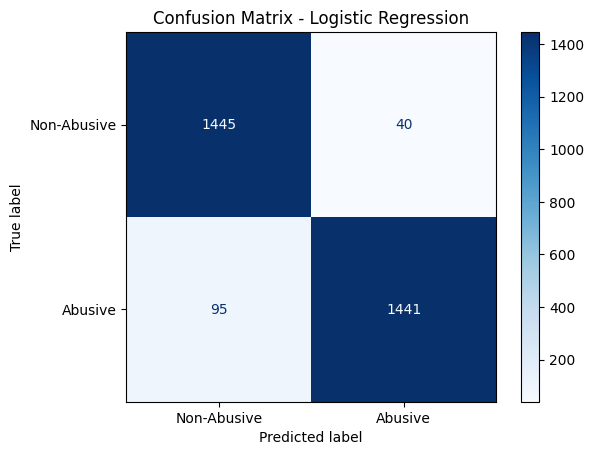


===== Multinomial Naive Bayes Confusion Matrix =====
[[1231  254]
 [  47 1489]]


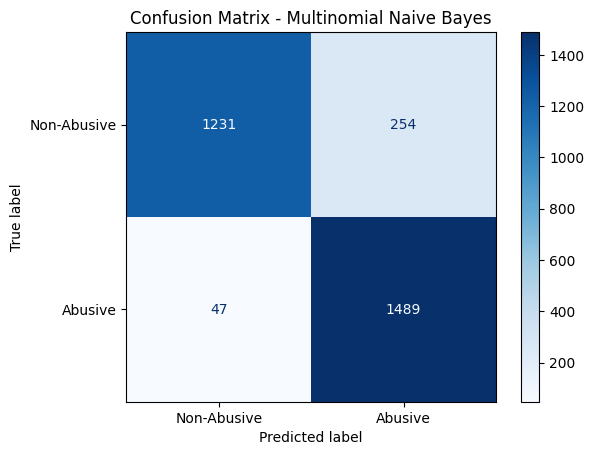


===== Support Vector Machine Confusion Matrix =====
[[1455   30]
 [  76 1460]]


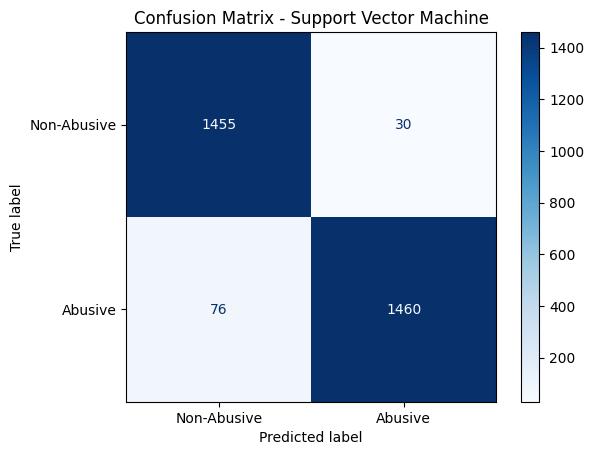

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate and display confusion matrix for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    print(f"\n===== {name} Confusion Matrix =====")
    print(cm)  # TN, FP, FN, TP

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Abusive", "Abusive"])
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()


### Observations from Confusion Matrices

- **Logistic Regression**  
  - **TN = 1445, FP = 40, FN = 95, TP = 1441**  
  - Very few False Positives (40) and False Negatives (95).  
  - Balanced performance between abusive and non-abusive detection.  

- **Multinomial Naïve Bayes**  
  - **TN = 1231, FP = 254, FN = 47, TP = 1489**  
  - Much higher False Positives (254) → many non-abusive comments flagged incorrectly.  
  - Very low False Negatives (47) → catches almost all abusive cases (strong recall).  

- **Support Vector Machine (SVM)**  
  - **TN = 1455, FP = 30, FN = 76, TP = 1460**  
  - Lowest overall misclassifications.  
  - Very few False Positives (30) and False Negatives (76).  
  - Strongest balance, making it the most effective model in confusion matrix comparison.  


### Final Conclusion
Among the three models:  
- **SVM performed best overall**, achieving the lowest misclassifications and the strongest balance between precision and recall.  
- **Logistic Regression** also performed strongly and serves as a reliable baseline model.  
- **Naïve Bayes** achieved the highest recall for abusive comments, making it valuable in scenarios where detecting all abusive cases is more important than reducing false positives.  

---> Overall, **SVM is the most effective model for cyber abuse detection on this dataset.**


###**8. Accuracy & Metrics Evaluation**



                         Accuracy  Precision    Recall  F1-Score
Logistic Regression      0.955313   0.955944  0.955313  0.955312
Multinomial Naive Bayes  0.900364   0.907829  0.900364  0.899777
Support Vector Machine   0.964912   0.965362  0.964912  0.964913


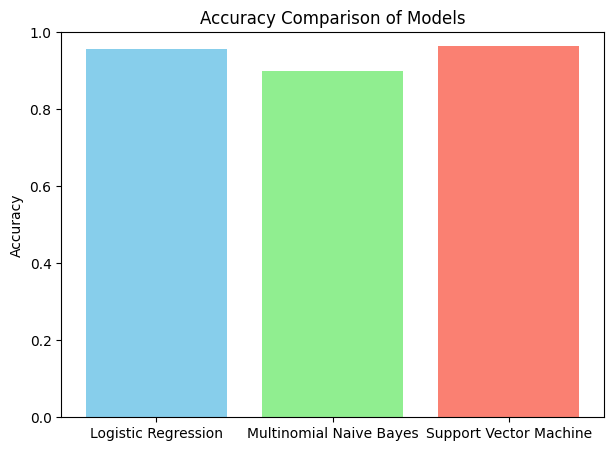

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Train models and store evaluation results
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average="weighted"),
        "Recall": recall_score(y_test, y_pred, average="weighted"),
        "F1-Score": f1_score(y_test, y_pred, average="weighted")
    }

# Convert results to a nice format
import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)

# Plot accuracy comparison
plt.figure(figsize=(7,5))
plt.bar(results_df.index, results_df["Accuracy"], color=["skyblue", "lightgreen", "salmon"])
plt.title("Accuracy Comparison of Models")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.show()


## Final Conclusion  

Based on the evaluation metrics (Accuracy, Precision, Recall, and F1-Score), the performance of the three models is summarized below:  

| Model                     | Accuracy | Precision | Recall | F1-Score |
|----------------------------|----------|-----------|--------|----------|
| Logistic Regression        | 0.9553   | 0.9559    | 0.9553 | 0.9553   |
| Multinomial Naïve Bayes    | 0.9004   | 0.9078    | 0.9004 | 0.8998   |
| Support Vector Machine     | 0.9649   | 0.9654    | 0.9649 | 0.9649   |

---

### Key Takeaways  

- **Support Vector Machine (SVM)**  
  - Achieved the highest scores across all metrics.  
  - Accuracy: ~96.5%, Precision: ~96.5%, Recall: ~96.5%, F1-Score: ~96.5%.  
  - Best suited for this cyber abuse detection task.  

- **Logistic Regression**  
  - Strong baseline with ~95.5% accuracy.  
  - Reliable balance between precision and recall.  

- **Multinomial Naïve Bayes**  
  - Lowest performance with ~90% accuracy.  
  - Still useful due to speed and simplicity, but prone to more misclassifications.  

---

### Final Decision  

Among the tested models, **Support Vector Machine (SVM)** is the most effective algorithm for cyber abuse detection in this dataset. Logistic Regression can serve as a strong alternative baseline, while Multinomial Naïve Bayes, though efficient, is less accurate and therefore less suitable for critical applications.  


In [27]:
import joblib

# Save the best model (SVM from your models dict)
joblib.dump(models["Support Vector Machine"], "cyber_abuse_model.pkl")

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, "vectorizer.pkl")

print("✅ Model and vectorizer saved successfully!")


✅ Model and vectorizer saved successfully!
